In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from glob import glob
from PIL import Image
from random import shuffle
from scipy.stats import pearsonr

In [3]:
# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'
# census index data
IDX_IN_DIR = 'data/Experiment0/satellite_initialization.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/satellite_download_log.csv'
# satellite derived data
SAT_IN_DIR = 'data/GoogleStaticMap/Pred/infer/annotations_pred.json'
# visual path
VIZ_DIR = 'data/GoogleStaticMap/Visual/infer/pred'
# output path
OUT_DIR = 'data/Experiment0/Output/'
# score cutoff
SCORE_CUTOFF = 0.6

In [4]:
# read image index data frame
df = pd.merge(pd.read_csv(IDX_IN_DIR, index_col='index'),
              pd.read_csv(LOG_IN_DIR, index_col='index'),
              how='left', on='index')
# drop NA localities with no images
df = df.loc[df['status'].astype('bool'),
            ['ent', 'mun', 'loc', 'chip']]

In [5]:
# read satellite predictions
# from json annotations
with open(SAT_IN_DIR, 'r') as f:
    df_sat = json.load(f)
df_sat = [[ins['image_id_str'], ins['category_id'],
           ins['score'], ins['area']]
          for ins in df_sat]
# convert to data frames
df_sat = pd.DataFrame(
    df_sat, columns=['index', 'category_id', 'score', 'area'])
# drop low score predictions
df_sat = df_sat.loc[df_sat['score'] > SCORE_CUTOFF, :]
df_sat.set_index('index', inplace=True)
# merge with image identifiers
df_sat = pd.merge(df, df_sat, how='left', on='index')
df_sat.set_index(['ent', 'mun', 'loc'], inplace=True)

In [6]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR, index_col=['ent', 'mun', 'loc'])

In [7]:
# merge satellite and census
df = pd.merge(df_sat, df_cen, how='left', on=['ent', 'mun', 'loc'])

In [8]:
# grouping into localities
df_group = df.groupby(['ent', 'mun', 'loc', 'sample']).agg(
    cen_pop=pd.NamedAgg(column='POBTOT', aggfunc=np.nanmean),
    cen_house=pd.NamedAgg(column='VIVTOT', aggfunc=np.nanmean),
    cen_inhab=pd.NamedAgg(column='TVIVHAB', aggfunc=np.nanmean),
    cen_vph_snbien=pd.NamedAgg(column='VPH_SNBIEN', aggfunc=np.nanmean),
    cen_vph_1cuart=pd.NamedAgg(column='VPH_1CUART', aggfunc=np.nanmean),
    cen_vph_3ymasc=pd.NamedAgg(column='VPH_3YMASC', aggfunc=np.nanmean),
    cen_vph_refri=pd.NamedAgg(column='VPH_REFRI', aggfunc=np.nanmean),
    cen_vph_autom=pd.NamedAgg(column='VPH_AUTOM', aggfunc=np.nanmean),
    sat_house=pd.NamedAgg(column='score', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
    sat_size_std=pd.NamedAgg(column='area', aggfunc=np.nanstd)
)

In [9]:
# select main + large sample
df_group = pd.concat([
    # this is to recover the initial distribution of locality sizes
    df_group.xs('main', level='sample').sample(n=130),
    df_group.xs('large', level='sample'),
])

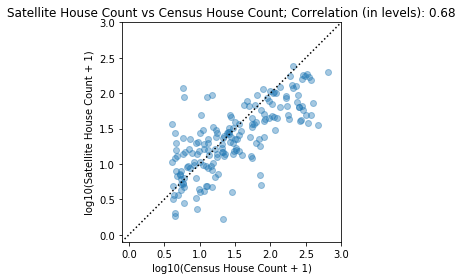

In [10]:
col_x_label = 'Census House Count'
col_x_name = 'cen_house'
col_y_label = 'Satellite House Count'
col_y_name = 'sat_house'
lims = (-0.1, 3)
# plotting begins
col_x = df_group.loc[:, col_x_name].values
col_y = df_group.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1 + np.random.random(len(col_x)) * 1),
    np.log10(col_y + 1 + np.random.random(len(col_y)) * 1),
    marker='o', linestyle='None', alpha=0.4)
plt.plot(lims, lims, 'k:')
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

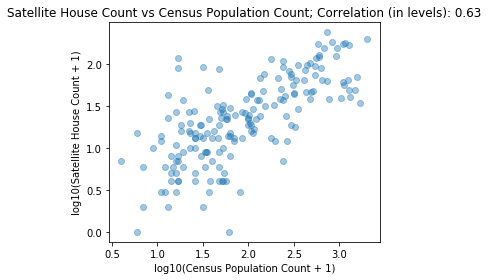

In [11]:
col_x_label = 'Census Population Count'
col_x_name = 'cen_pop'
col_y_label = 'Satellite House Count'
col_y_name = 'sat_house'
# plotting begins
col_x = df_group.loc[:, col_x_name].values
col_y = df_group.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1),
    np.log10(col_y + 1),
    marker='o', linestyle='None', alpha=0.4)
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

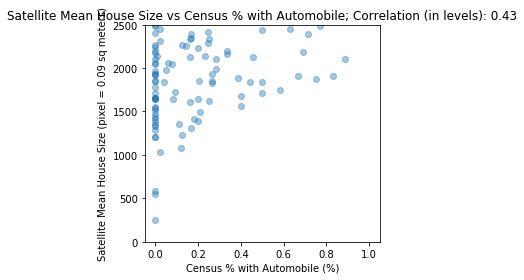

In [12]:
col_x_label = 'Census % with Automobile'
col_x_name = 'cen_vph_autom'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.ylim((0, 2500))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (pixel = 0.09 sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

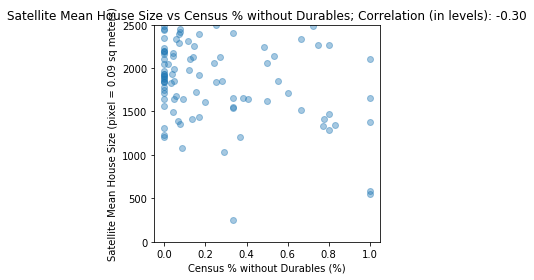

In [13]:
col_x_label = 'Census % without Durables'
col_x_name = 'cen_vph_snbien'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.ylim((0, 2500))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (pixel = 0.09 sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

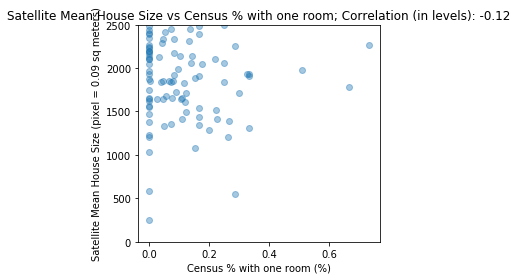

In [14]:
col_x_label = 'Census % with one room'
col_x_name = 'cen_vph_1cuart'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.ylim((0, 2500))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (pixel = 0.09 sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

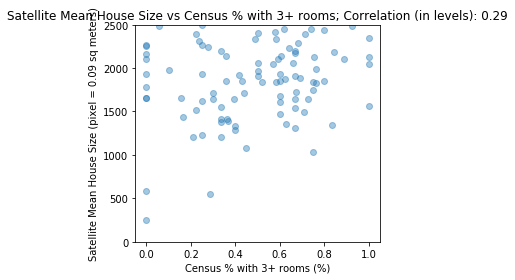

In [15]:
col_x_label = 'Census % with 3+ rooms'
col_x_name = 'cen_vph_3ymasc'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.ylim((0, 2500))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (pixel = 0.09 sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

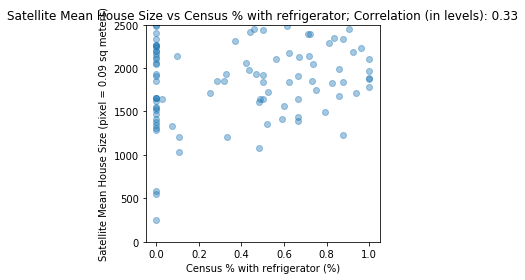

In [16]:
col_x_label = 'Census % with refrigerator'
col_x_name = 'cen_vph_refri'
col_y_label = 'Satellite Mean House Size'
col_y_name = 'sat_size_mean'
# plotting begins
tmp = df_group.loc[:, [col_x_name, col_y_name]].dropna()
col_x = tmp.loc[:, col_x_name].values
col_y = tmp.loc[:, col_y_name].values
coef = pearsonr(col_x, col_y)
plt.plot(
    col_x,
    col_y,
    marker='o', linestyle='None', alpha=0.4)
plt.ylim((0, 2500))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('{} (%)'.format(col_x_label))
plt.ylabel('{} (pixel = 0.09 sq meters)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}.pdf'
                         .format(col_x_name, col_y_name)))
plt.show()

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f3af9939650> returned a result with an error set

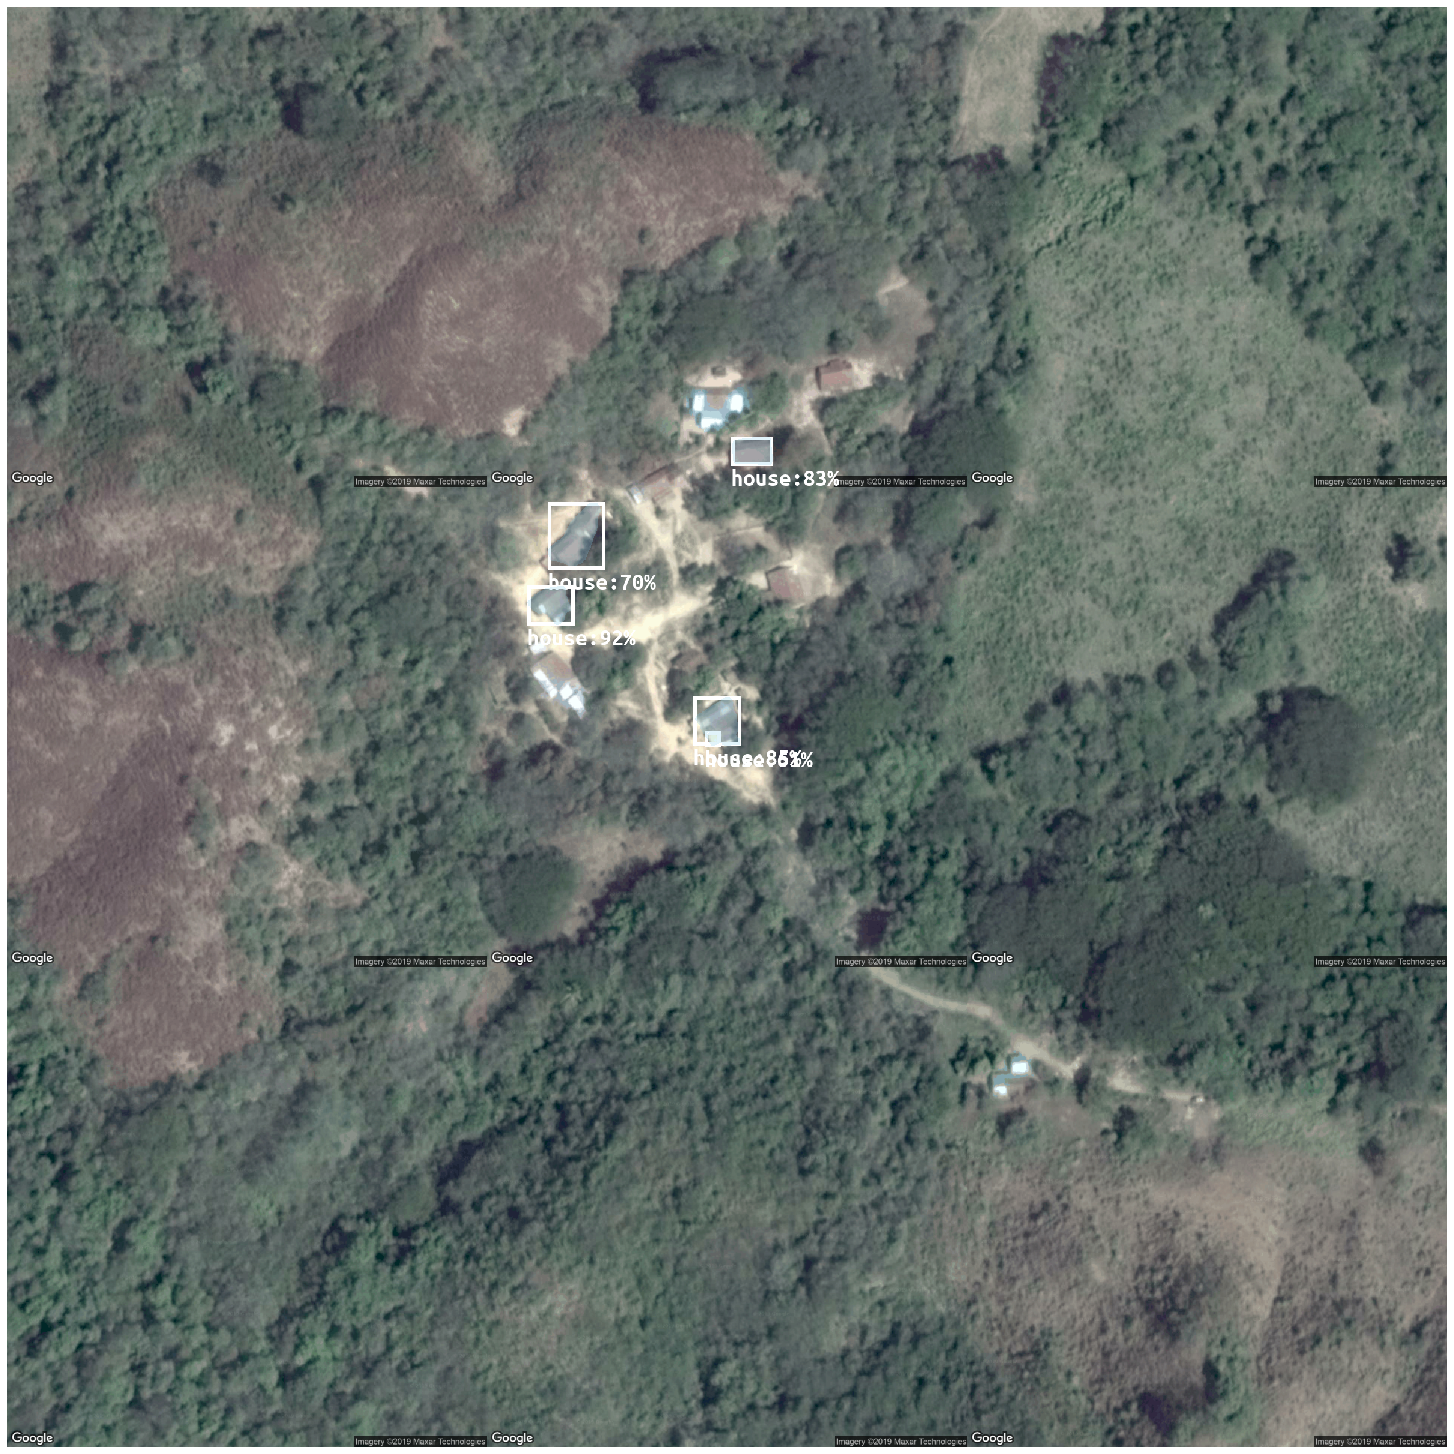

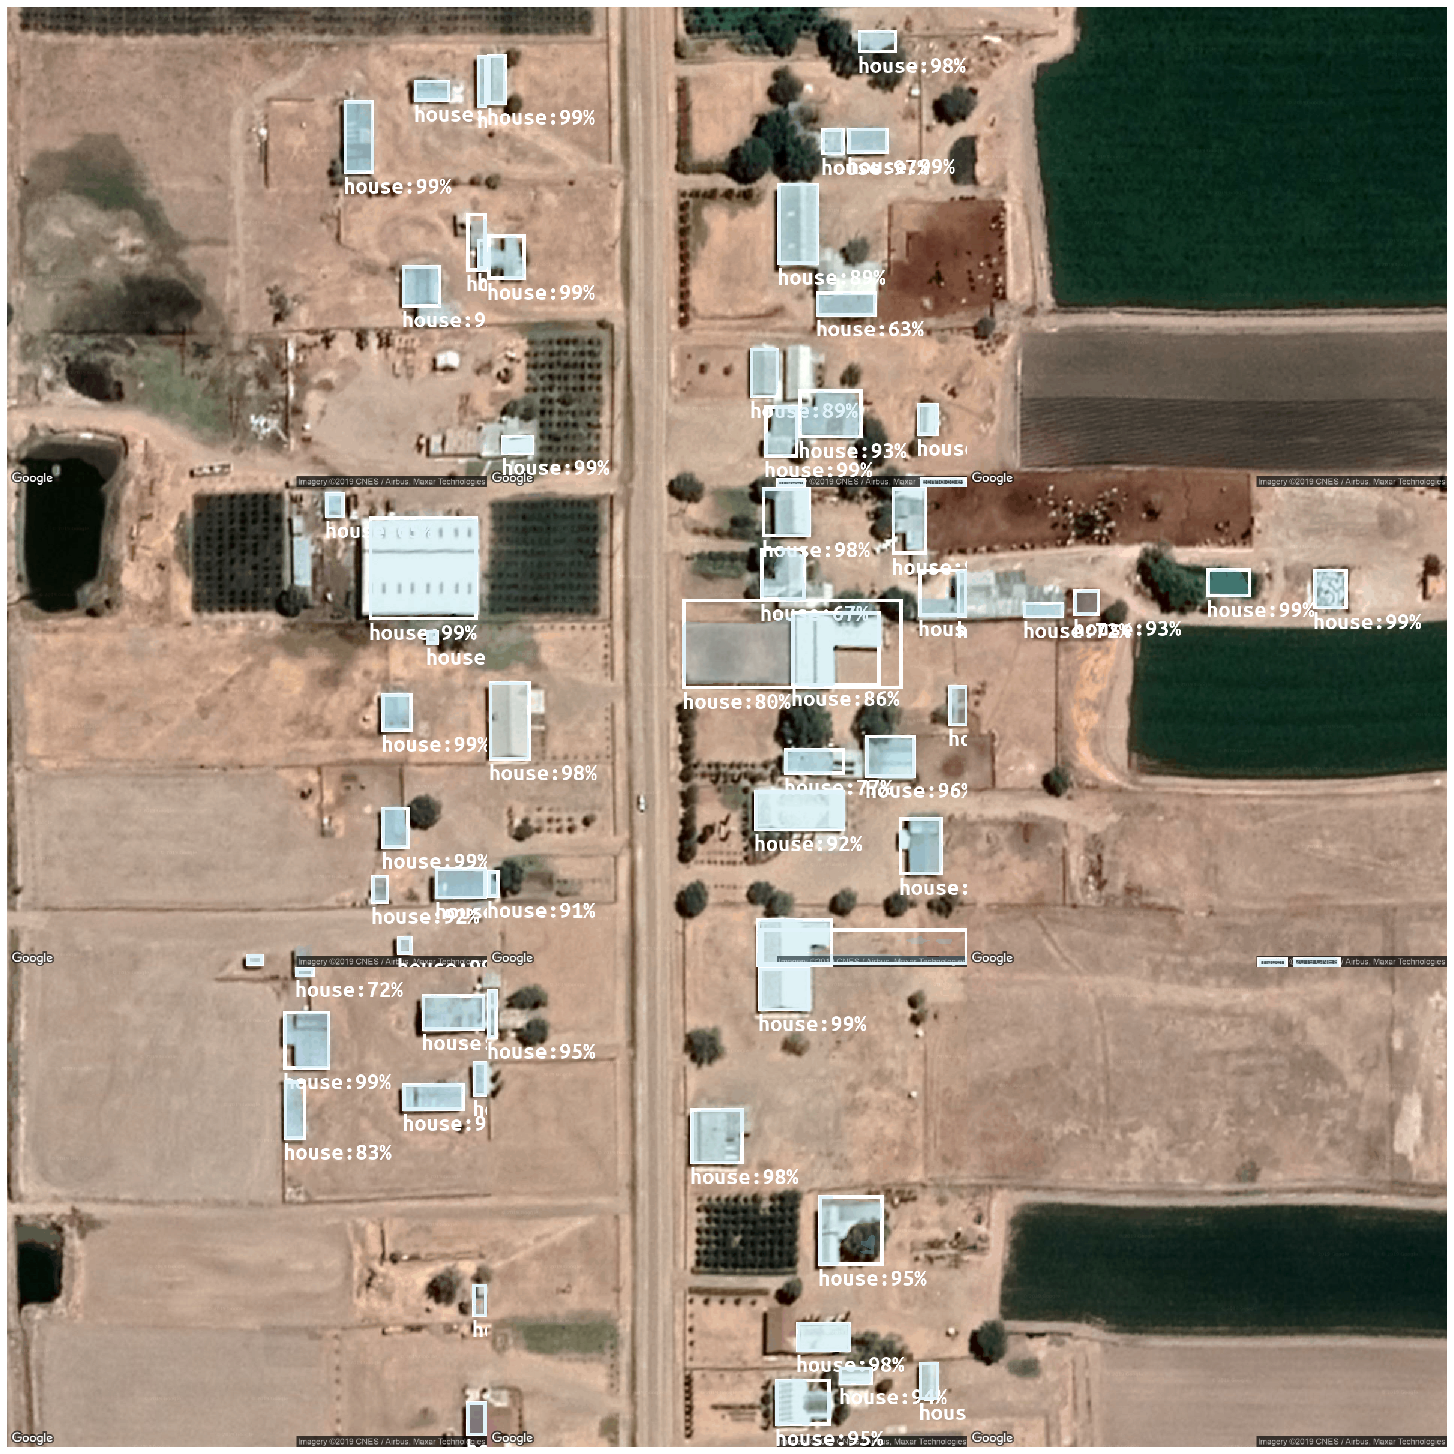

In [17]:
for _ in range(5):
    # randomly sample one chip
    df_sampled = df_group.sample(n=1)
    ent, mun, loc = df_sampled.index[0]
    # show inference image
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    fig.subplots_adjust(
        hspace=0, wspace=0, right=1, bottom=0, left=0, top=1)
    for i in range(3):
        for j in range(3):
            chip_id = (2 - i) * 3 + j
            im = plt.imread(os.path.join(
                VIZ_DIR,
                'ENT{:02d}MUN{:03d}LOC{:04d}CHIP{:02d}.png'
                .format(ent, mun, loc, chip_id)))
            ax[i, j].imshow(im)
            ax[i, j].axis('off')
    fig.savefig(os.path.join(
        OUT_DIR, 'ENT{:02d}MUN{:03d}LOC{:04d}CEN{:03d}SAT{:03d}.png'
                 .format(ent, mun, loc,
                         int(df_sampled['cen_house']),
                         int(df_sampled['sat_house']))))